# Model

In [1]:
%load_ext autoreload
%autoreload 2

import os

In [2]:
path_list = os.getcwd().split('\\')
if path_list[-1] == 'src':
    print(os.getcwd())
else:
    os.chdir('..')
    print(os.getcwd())

F:\study\Hackatons\DashboardSber\src


In [631]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', None)

from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import HDBSCAN, Birch, BisectingKMeans, KMeans, MeanShift
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Загрузка данных

In [484]:
def fix_date_columns(df):
    new_columns = [df.columns[0]]
    for column in df.columns[1:]:
        date = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(column) - 2).strftime('%Y-%m-%d')
        new_columns.append(date)

    df.columns = new_columns
    return df


df_acquiring = pd.read_excel(
    io='dataset/acquiring.xlsb',
    engine='pyxlsb',
    header=1,  # У файла есть заголовок-объединение
    # nrows=1000,
)
df_acquiring = fix_date_columns(df_acquiring)

# df_rko = pd.read_excel(
#     io='dataset/rko.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )
# df_rko = fix_date_columns(df_rko)

# df_economy_acquiring = pd.read_excel(
#     io='dataset/economy_acquiring.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

# df_economy_general = pd.read_excel(
#     io='dataset/economy_general.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

df_general = pd.read_excel(
    io='dataset/general.xlsb',
    engine='pyxlsb',
    header=0,  # У файла есть заголовок-объединение
)
df_general['Кластер'] = df_general['Кластер'].astype('category')
df_general = df_general.drop(['ОКВЭД, основная деятельность', 'ОКВЭД, дополнительные', 'Наименование основного ОКВЭД'], axis=1)
df_general

In [483]:
df_acquiring.head()

,клиент,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,client_37877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
1,client_30115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
2,client_9554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,client_42590,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,client_14578,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1


# Расчёт двух формул

In [141]:
def customer_churn_share(df: pd.DataFrame, end_id_month: int) -> float:
    """Доля оттока клиентов."""
    have_clients = df.iloc[:, end_id_month - 1]
    have_clients = have_clients[have_clients == 1]

    not_have_clients = df.iloc[have_clients.index, end_id_month]
    not_have_clients = not_have_clients[not_have_clients == 0]

    value = not_have_clients.shape[0] / have_clients.shape[0] * 100
    return value


customer_churn_share(df_acquiring, 2)

3.225806451612903

In [125]:
def customer_survival_rate(df: pd.DataFrame, end_id_month: int) -> float:
    """Расчет процента выживаемости клиентов"""
    start_clients = df.iloc[:, end_id_month - 1]
    start_clients = start_clients[start_clients == 1]

    left_clients = df.iloc[start_clients.index, end_id_month]
    left_clients = left_clients[left_clients == 0]

    df_copy = df.copy()
    df_copy = df_copy.drop(start_clients.index, axis=0)
    new_clients = df_copy.iloc[:, end_id_month]
    new_clients = new_clients[new_clients == 1]

    end_clients = start_clients.shape[0] - left_clients.shape[0] + new_clients.shape[0]
    value = ((end_clients - new_clients.shape[0]) / start_clients.shape[0]) * 100
    return value


customer_survival_rate(df_acquiring, 2)

96.7741935483871

# Feature Engineering

### Создание 3 таргетов

In [128]:
series_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")==False].values
level_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")].values

In [142]:
lst_customer_churn_share = [customer_churn_share(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
len(lst_customer_churn_share)

23

In [143]:
lst_customer_survival_rate = [customer_survival_rate(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
len(lst_customer_survival_rate)

23

In [162]:
df_cr_pr = pd.DataFrame(series_cols[1:], columns=["ds"])
df_cr_pr['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df_cr_pr.loc[:, "cr"] = lst_customer_churn_share
df_cr_pr.loc[:, "pr"] = lst_customer_survival_rate
df_cr_pr.head()

,ds,cr,pr
0,2021-11-30,3.225806,96.774194
1,2021-12-31,1.104972,98.895028
2,2022-01-31,1.104972,98.895028
3,2022-02-28,1.648352,98.351648
4,2022-03-31,1.111111,98.888889


### Новые признаки для модели

In [620]:
df_general_encoded = pd.get_dummies(df_general, columns=['Средний возраст работников', 'Тип организации'])
df_general_encoded = df_general_encoded.replace(True, 1).replace(False, 0)
df_general_encoded = df_general_encoded.replace('нет данных', 0)
df_general_encoded[['Сегмент id', 'Кластер']] = df_general_encoded[['Сегмент id', 'Кластер']].astype('int')
df_general_encoded.head(2)

,клиент,Сегмент id,Кластер,bank_1,bank_2,bank_3,bank_4,bank_5,bank_6,bank_7,bank_8,bank_9,bank_10,bank_11,bank_12,bank_13,bank_14,bank_15,bank_16,bank_17,bank_18,bank_19,bank_20,bank_21,bank_22,bank_23,bank_24,bank_25,bank_26,bank_27,bank_28,bank_29,bank_30,bank_31,bank_32,bank_33,bank_34,bank_35,bank_36,bank_37,bank_38,bank_39,bank_40,bank_41,bank_42,bank_43,bank_44,bank_45,bank_46,bank_47,bank_48,bank_49,bank_50,ns_promotion,acquiring_mobile,acreditiv,arenda_seyf,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,broker,capital_markets,cash_management,dbo,dcd,deposit_sertificat,einvoicing,eko_docdoc,eko_interkomp,eko_korus,eko_sbermobile,eko_segmento,eko_tot,factoring,garantee_gos,garantee_kontract,garantee_other,invest_kredit,itog_bank,itog_eko,kbk,konversion,mb_a,ns_bukh,ns_business,ns_document,ns_in_app,nso,ns_priem_plat,ns_servis,ns_terminal,ns_torg,oborot_kredit,obsluzh_rts_rur,obsluzh_rts_val,overdraft_kredit,pfi,products_lizing,proekt_finans,spec_acc,us,veksel,bank_guarantees,credit,corporate_cards,valuta_control,deposit,inkass,acquiring_torg,rko,zarplat_projects,samoinkass,Компания в стадии ликвидации,Средний возраст работников_>=48,Средний возраст работников_[0-27),Средний возраст работников_[27-34),Средний возраст работников_[34-40),Средний возраст работников_[40-48),Средний возраст работников_нет данных,Тип организации_ИП,Тип организации_Филиал,Тип организации_Юр. лицо
0,client_5139,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
1,client_16112,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0


In [869]:
START_PERIOD = 1

In [870]:
features1 = {f'{key}1': [] for key in df_general_encoded.columns[1:]}

for i in range(START_PERIOD, df_acquiring.shape[1]):
    tmp = df_acquiring.iloc[:, i]
    tmp = tmp[tmp == 1]

    for key, value in df_general_encoded.iloc[tmp.index].iloc[:, 1:].mean().items():
        features1[f'{key}1'].append(value)

In [871]:
features0 = {f'{key}0': [] for key in df_general_encoded.columns[1:]}

for i in range(START_PERIOD, df_acquiring.shape[1]):
    tmp = df_acquiring.iloc[:, i]
    tmp = tmp[tmp == 0]

    for key, value in df_general_encoded.iloc[tmp.index].iloc[:, 1:].mean().items():
        features0[f'{key}0'].append(value)

# Модели

In [872]:
# Про prophet:
# https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet

In [873]:
# Много моделей prophet с features:
# https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/

In [885]:
TRAIN_END = -4

In [886]:
# timeseries = df_cr_pr.cr
# timeseries = df_cr_pr.pr
timeseries = df_acquiring[series_cols].sum().values

len(timeseries)

24

In [887]:
train_timeseries = timeseries[0:TRAIN_END]
eval_timeseries = timeseries[TRAIN_END::]
print(len(train_timeseries), len(eval_timeseries))

days = np.arange(1, len(train_timeseries) + len(eval_timeseries) + 1)
len(days)

20 4


24

In [888]:
df = pd.DataFrame(series_cols[len(series_cols) - len(days):], columns=["ds"])
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df.loc[:, "y"] = timeseries

df.loc[:, "cap"] = df.y.max()
df.loc[:, "floor"] = df.y.min()
# df.loc[:, "cap"] = 100
# df.loc[:, "floor"] = 0

for key, value in features1.items():
    df[key] = value
for key, value in features0.items():
    df[key] = value

print(df.shape)
df.tail()

(24, 246)


,ds,y,cap,floor,Сегмент id1,Кластер1,bank_11,bank_21,bank_31,bank_41,bank_51,bank_61,bank_71,bank_81,bank_91,bank_101,bank_111,bank_121,bank_131,bank_141,bank_151,bank_161,bank_171,bank_181,bank_191,bank_201,bank_211,bank_221,bank_231,bank_241,bank_251,bank_261,bank_271,bank_281,bank_291,bank_301,bank_311,bank_321,bank_331,bank_341,bank_351,bank_361,bank_371,bank_381,bank_391,bank_401,bank_411,bank_421,bank_431,bank_441,bank_451,bank_461,bank_471,bank_481,bank_491,bank_501,ns_promotion1,acquiring_mobile1,acreditiv1,arenda_seyf1,bank_straxovanie_imush1,bank_straxovanie_lich1,bank_straxovanie_otvet1,broker1,capital_markets1,cash_management1,dbo1,dcd1,deposit_sertificat1,einvoicing1,eko_docdoc1,eko_interkomp1,eko_korus1,eko_sbermobile1,eko_segmento1,eko_tot1,factoring1,garantee_gos1,garantee_kontract1,garantee_other1,invest_kredit1,itog_bank1,itog_eko1,kbk1,konversion1,mb_a1,ns_bukh1,ns_business1,ns_document1,ns_in_app1,nso1,ns_priem_plat1,ns_servis1,ns_terminal1,ns_torg1,oborot_kredit1,obsluzh_rts_rur1,obsluzh_rts_val1,overdraft_kredit1,pfi1,products_lizing1,proekt_finans1,spec_acc1,us1,veksel1,bank_guarantees1,credit1,corporate_cards1,valuta_control1,deposit1,inkass1,acquiring_torg1,rko1,zarplat_projects1,samoinkass1,Компания в стадии ликвидации1,Средний возраст работников_>=481,Средний возраст работников_[0-27)1,Средний возраст работников_[27-34)1,Средний возраст работников_[34-40)1,Средний возраст работников_[40-48)1,Средний возраст работников_нет данных1,Тип организации_ИП1,Тип организации_Филиал1,Тип организации_Юр. лицо1,Сегмент id0,Кластер0,bank_10,bank_20,bank_30,bank_40,bank_50,bank_60,bank_70,bank_80,bank_90,bank_100,bank_110,bank_120,bank_130,bank_140,bank_150,bank_160,bank_170,bank_180,bank_190,bank_200,bank_210,bank_220,bank_230,bank_240,bank_250,bank_260,bank_270,bank_280,bank_290,bank_300,bank_310,bank_320,bank_330,bank_340,bank_350,bank_360,bank_370,bank_380,bank_390,bank_400,bank_410,bank_420,bank_430,bank_440,bank_450,bank_460,bank_470,bank_480,bank_490,bank_500,ns_promotion0,acquiring_mobile0,acreditiv0,arenda_seyf0,bank_straxovanie_imush0,bank_straxovanie_lich0,bank_straxovanie_otvet0,broker0,capital_markets0,cash_management0,dbo0,dcd0,deposit_sertificat0,einvoicing0,eko_docdoc0,eko_interkomp0,eko_korus0,eko_sbermobile0,eko_segmento0,eko_tot0,factoring0,garantee_gos0,garantee_kontract0,garantee_other0,invest_kredit0,itog_bank0,itog_eko0,kbk0,konversion0,mb_a0,ns_bukh0,ns_business0,ns_document0,ns_in_app0,nso0,ns_priem_plat0,ns_servis0,ns_terminal0,ns_torg0,oborot_kredit0,obsluzh_rts_rur0,obsluzh_rts_val0,overdraft_kredit0,pfi0,products_lizing0,proekt_finans0,spec_acc0,us0,veksel0,bank_guarantees0,credit0,corporate_cards0,valuta_control0,deposit0,inkass0,acquiring_torg0,rko0,zarplat_projects0,samoinkass0,Компания в стадии ликвидации0,Средний возраст работников_>=480,Средний возраст работников_[0-27)0,Средний возраст работников_[27-34)0,Средний возраст работников_[34-40)0,Средний возраст работников_[40-48)0,Средний возраст работников_нет данных0,Тип организации_ИП0,Тип организации_Филиал0,Тип организации_Юр. лицо0
19,2023-05-31,7017,8546,159,0.062277,6.100755,0.000285,0.0,0.000000,0.000285,0.0,0.003278,0.0,0.0,0.034773,0.0,0.000285,0.0,0.0,0.001140,0.000855,0.003848,0.000713,0.002565,0.0,0.000143,0.003705,0.000143,0.0,0.031637,0.000143,0.0,0.001710,0.000428,0.002138,0.000143,0.0,0.017671,0.000143,0.0,0.000143,0.000143,0.000855,0.0,0.000570,0.0,0.000285,0.0,0.0,0.0,0.0,0.0,0.0,0.001995,0.0,0.0,0.0,0.003848,0.000713,0.0,0.000998,0.002850,0.000285,0.0,0.0,0.001140,0.728944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000428,0.000285,0.000285,2.617358,0.303264,0.0,0.000428,0.000143,0.003420,0.000000,0.012826,0.193530,0.000570,0.002280,0.0,0.0,0.000143,0.021519,0.664529,0.000428,0.003278,0.000143,0.000428,0.000428,0.0,0.0,0.000143,0.000428,0.034630,0.249964,0.011971,0.009548,0.001283,0.172438,0.943708,0.494086,0.022232,0.111729,0.151632,0.134673,0.131965,0.147071,0.134388,0.300271,0.701724,0.0,0.298276,0.067575,6.1

In [889]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

select = SelectKBest(r_regression, k=15)
X_selection = select.fit_transform(df.iloc[:, 4:], df.iloc[:, 1])

In [890]:
best_columns = df.iloc[:, 4:].columns[select.get_support()].tolist()
best_columns

['cash_management1',
 'bank_50',
 'bank_70',
 'bank_80',
 'bank_190',
 'bank_380',
 'bank_400',
 'bank_410',
 'bank_460',
 'bank_straxovanie_imush0',
 'broker0',
 'factoring0',
 'acquiring_torg0',
 'Средний возраст работников_[40-48)0',
 'Тип организации_Филиал0']

In [891]:
df = df.iloc[:, :4].join(df[best_columns])
df.head(2)

,ds,y,cap,floor,cash_management1,bank_50,bank_70,bank_80,bank_190,bank_380,bank_400,bank_410,bank_460,bank_straxovanie_imush0,broker0,factoring0,acquiring_torg0,Средний возраст работников_[40-48)0,Тип организации_Филиал0
0,2021-10-31,186,8546,159,0.0,0.000021,0.000083,0.000083,0.000041,0.000062,0.000021,0.000622,0.000083,0.001472,0.000021,0.000021,0.176586,0.139976,0.000083
1,2021-11-30,181,8546,159,0.0,0.000021,0.000083,0.000083,0.000041,0.000062,0.000021,0.000622,0.000083,0.001472,0.000021,0.000021,0.176589,0.140023,0.000083


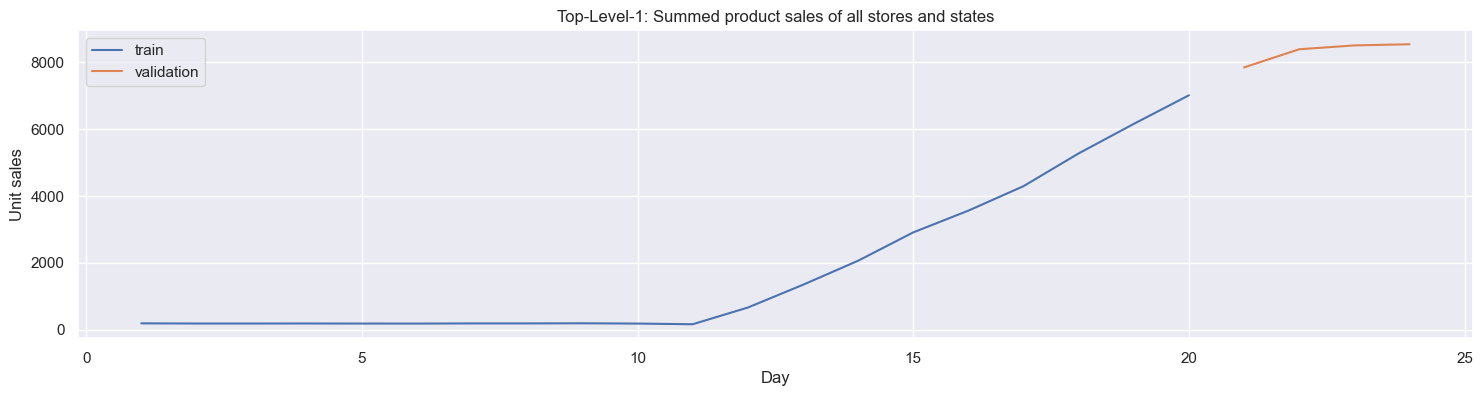

In [892]:
plt.figure(figsize=(18, 4))
plt.plot(days[0:TRAIN_END], train_timeseries, label="train")
plt.plot(days[TRAIN_END::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

In [893]:
train_df = df.iloc[0:TRAIN_END]
print(train_df.shape)

eval_df = df.iloc[TRAIN_END::]
print(eval_df.shape)

(20, 19)
(4, 19)


In [894]:
eval_df

,ds,y,cap,floor,cash_management1,bank_50,bank_70,bank_80,bank_190,bank_380,bank_400,bank_410,bank_460,bank_straxovanie_imush0,broker0,factoring0,acquiring_torg0,Средний возраст работников_[40-48)0,Тип организации_Филиал0
20,2023-06-30,7852,8546,159,0.001274,0.000025,0.000099,0.000099,0.000049,0.000074,0.000025,0.000690,0.000099,0.001577,0.000025,0.000025,0.177615,0.140963,0.000099
21,2023-07-31,8396,8546,159,0.001191,0.000025,0.000100,0.000100,0.000050,0.000075,0.000025,0.000700,0.000100,0.001574,0.000025,0.000025,0.177330,0.141030,0.000100
22,2023-08-31,8511,8546,159,0.001175,0.000025,0.000100,0.000100,0.000050,0.000075,0.000025,0.000702,0.000100,0.001578,0.000025,0.000025,0.177465,0.141135,0.000100
23,2023-09-30,8546,8546,159,0.001170,0.000025,0.000100,0.000100,0.000050,0.000075,0.000025,0.000702,0.000100,0.001605,0.000025,0.000025,0.177571,0.141109,0.000100


In [895]:
# changepoint_prior_scale - используется для контроля гибкости тренда, чтобы избежать переобучения или недоподготовки

# model = Prophet(growth='logistic', changepoint_prior_scale=2.5)
model = Prophet()
for feature in df.columns[4:]:
    model.add_regressor(feature)
model.fit(train_df)

# future = model.make_future_dataframe(periods=abs(TRAIN_END), freq='M')
# future['tmp'] = [np.random.randint(-50, 50) for i in range(future.shape[0])]

pred = model.predict(eval_df)
pred.index = eval_df.index

pred.head()

23:53:48 - cmdstanpy - INFO - Chain [1] start processing
23:54:02 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,acquiring_torg0,acquiring_torg0_lower,acquiring_torg0_upper,additive_terms,additive_terms_lower,additive_terms_upper,bank_190,bank_190_lower,bank_190_upper,bank_380,bank_380_lower,bank_380_upper,bank_400,bank_400_lower,bank_400_upper,bank_410,bank_410_lower,bank_410_upper,bank_460,bank_460_lower,bank_460_upper,bank_50,bank_50_lower,bank_50_upper,bank_70,bank_70_lower,bank_70_upper,bank_80,bank_80_lower,bank_80_upper,bank_straxovanie_imush0,bank_straxovanie_imush0_lower,bank_straxovanie_imush0_upper,broker0,broker0_lower,broker0_upper,cash_management1,cash_management1_lower,cash_management1_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,factoring0,factoring0_lower,factoring0_upper,Средний возраст работников_[40-48)0,Средний возраст работников_[40-48)0_lower,Средний возраст работников_[40-48)0_upper,Тип организации_Филиал0,Тип организации_Филиал0_lower,Тип организации_Филиал0_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
20,2023-06-30,1441.575401,8546,7958.911370,7986.569716,1426.564214,1454.222560,92.621795,92.621795,92.621795,6532.347155,6532.347155,6532.347155,-17114.791851,-17114.791851,-17114.791851,-1820.121496,-1820.121496,-1820.121496,19707.201981,19707.201981,19707.201981,187.867829,187.867829,187.867829,4959.800072,4959.800072,4959.800072,8543.063429,8543.063429,8543.063429,-31137.745803,-31137.745803,-31137.745803,19249.338451,19249.338451,19249.338451,66.369453,66.369453,66.369453,6969.076675,6969.076675,6969.076675,185.478588,185.478588,185.478588,6532.347155,6532.347155,6532.347155,-9881.698655,-9881.698655,-9881.698655,87.928521,87.928521,87.928521,6437.958165,6437.958165,6437.958165,0.0,0.0,0.0,7973.922557
21,2023-07-31,1330.176945,8546,8434.324733,8517.853946,1286.816067,1370.345280,60.329639,60.329639,60.329639,7147.508666,7147.508666,7147.508666,-18926.525229,-18926.525229,-18926.525229,-2012.795464,-2012.795464,-2012.795464,21793.362066,21793.362066,21793.362066,218.820739,218.820739,218.820739,5484.833354,5484.833354,5484.833354,9447.412913,9447.412913,9447.412913,-34433.917552,-34433.917552,-34433.917552,21287.030132,21287.030132,21287.030132,63.620910,63.620910,63.620910,7706.807460,7706.807460,7706.807460,171.766059,171.766059,171.766059,7147.508666,7147.508666,7147.508666,-10927.753052,-10927.753052,-10927.753052,95.050753,95.050753,95.050753,7119.465939,7119.465939,7119.465939,0.0,0.0,0.0,8477.685612
22,2023-08-31,1218.778490,8546,8456.177224,8614.834187,1140.111310,1298.768273,75.680118,75.680118,75.680118,7316.065914,7316.065914,7316.065914,-19315.844093,-19315.844093,-19315.844093,-2054.198693,-2054.198693,-2054.198693,22241.651800,22241.651800,22241.651800,225.472133,225.472133,225.472133,5597.656446,5597.656446,5597.656446,9641.746316,9641.746316,9641.746316,-35142.223673,-35142.223673,-35142.223673,21724.904612,21724.904612,21724.904612,67.138198,67.138198,67.138198,7865.336587,7865.336587,7865.336587,169.091721,169.091721,169.091721,7316.065914,7316.065914,7316.065914,-11152.537071,-11152.537071,-11152.537071,106.278069,106.278069,106.278069,7265.913444,7265.913444,7265.913444,0.0,0.0,0.0,8534.844404
23,2023-09-30,1110.973532,8546,8375.700383,8621.042853,987.621056,1232.963527,87.677566,87.677566,87.677566,7388.079327,7388.079327,7388.079327,-19434.778145,-19434.778145,-19434.778145,-2066.847074,-2066.847074,-2066.847074,22378.601019,22378.601019,22378.601019,227.504085,227.504085,227.504085,5632.123071,5632.123071,5632.123071,9701.113743,9701.113743,9701.113743,-35358.605987,-35358.605987,-35358.605987,21858.672047,21858.672047,21858.672047,87.661985,87.661985,87.661985,7913.766071,7913.766071,7913.766071,168.292079,168.292079,168.292079,7388.079327,7388.079327,7388.079327,-11221.206937,-11221.206937,-11221.206937,103.453724,103.453724,103.453724,7310.652080,7310.652080,7310.652080,0.0,0.0,0.0,8499.052859


In [896]:
col_int = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
pred[col_int].head()

,ds,yhat,yhat_lower,yhat_upper
20,2023-06-30,7973.922557,7958.911370,7986.569716
21,2023-07-31,8477.685612,8434.324733,8517.853946
22,2023-08-31,8534.844404,8456.177224,8614.834187
23,2023-09-30,8499.052859,8375.700383,8621.042853


In [897]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def metrics(y_true, y_pred):

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f'{rmse = }')

    mae = mean_absolute_error(y_true, y_pred)
    print(f'{mae = }')

    r2 = r2_score(y_true, y_pred)
    print(f'{r2 = }')

In [898]:
metrics(pred.yhat, eval_df.y)

rmse = 77.95870474959132
mae = 68.59992820447474
r2 = 0.8854880148196539


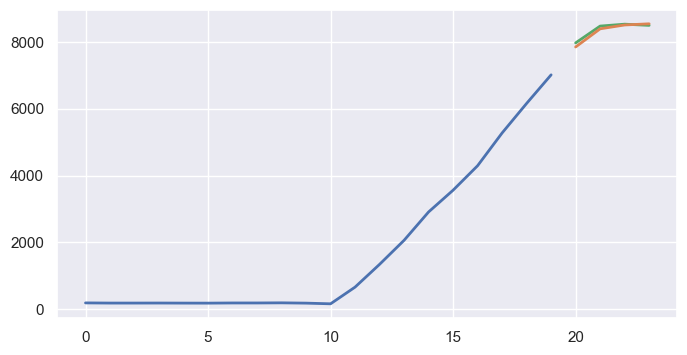

In [899]:
plt.figure(figsize=(8, 4))
plt.plot(pred.yhat, "g", label="prediction", linewidth=2.0)
plt.plot(train_df.y, label="actual", linewidth=2.0)
plt.plot(eval_df.y, label="actual", linewidth=2.0);

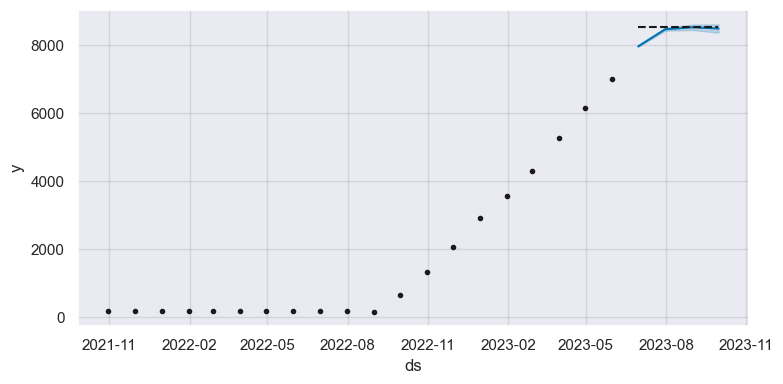

In [900]:
model.plot(pred, figsize=(8, 4));

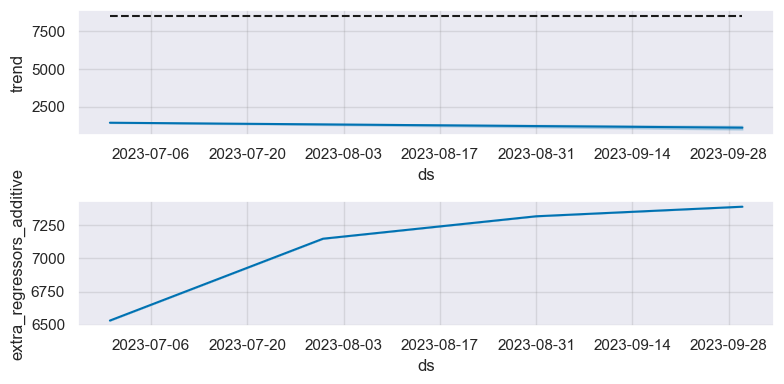

In [901]:
model.plot_components(pred, figsize=(8, 4));